# Modelli Mistura Gaussiani {#sec-stan-gaussian-mixture}

**Prerequisiti**

- Leggere [Mindfulness and affect-network density: Does mindfulness facilitate disengagement from affective experiences in daily life?](https://link.springer.com/content/pdf/10.1007/s12671-020-01335-4.pdf) di @rowland2020mindfulness.


**Concetti e competenze chiave**

- I modelli di mistura gaussiana sono strumenti per analizzare dati provenienti da popolazioni eterogenee, come spesso accade in psicologia.
- Nel tutorial simuleremo dati che rappresentano due gruppi distinti (mindfulness e controllo) e dimostreremo come un modello di mistura gaussiana possa identificare correttamente queste sottopopolazioni.
- L'uso di Stan per l'inferenza bayesiana ci permetterà di stimare i parametri del modello e quantificare l'incertezza associata a queste stime.
- La visualizzazione dei risultati fornisce intuizioni preziose sulla struttura dei dati.

**Preparazione del Notebook**

In [2]:
import logging
import os
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
import cmdstanpy
from cmdstanpy import CmdStanModel
cmdstanpy.utils.get_logger().setLevel(logging.ERROR)

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az
import scipy.stats as stats

In [3]:
seed: int = sum(map(ord, "stan_gaussian_mixture"))
rng: np.random.Generator = np.random.default_rng(seed=seed)
sns.set_theme(palette="colorblind")
az.style.use("arviz-darkgrid")
%config InlineBackend.figure_format = "retina"

# Get the home directory
home_directory = os.path.expanduser("~")
# Construct the path to the Quarto project directory 
project_directory = os.path.join(
    home_directory, '_repositories', 'psicometria')

## Introduzione {.unnumbered}

La distribuzione gaussiana è estremamente utile, non solo quando i dati seguono una distribuzione normale, ma anche in situazioni dove la distribuzione dei dati non è gaussiana. Un esempio rilevante è quello delle misture di distribuzioni. Una [mistura di distribuzioni](https://it.wikipedia.org/wiki/Mistura_di_distribuzioni) rappresenta una variabile casuale la cui funzione di probabilità (per variabili discrete) o funzione di densità di probabilità (per variabili continue) è data da una combinazione lineare ponderata di più funzioni di probabilità o densità di altre variabili casuali.

Ad esempio, la densità di probabilità di una mistura di due distribuzioni normali può essere espressa come:

$$
f(x; \pi_1, \mu_1, \sigma_1, \mu_2, \sigma_2) = \pi_1 \phi(x; \mu_1, \sigma_1) + \pi_2 \phi(x; \mu_2, \sigma_2)
$$

dove:

$$
\pi_2 = 1 - \pi_1
$$

e $\phi(x; \mu, \sigma)$ rappresenta la funzione di densità di probabilità di una variabile casuale normale con media $\mu$ e deviazione standard $\sigma$.

Un'applicazione comune delle misture di distribuzioni è il caso delle subpopolazioni. Quando una popolazione è composta da più sottopopolazioni, ciascuna con una propria distribuzione di valori, l'intera popolazione può essere modellata come una mistura di distribuzioni. Ad esempio, se si assume che l'altezza degli uomini e quella delle donne seguano entrambe una distribuzione normale, ma con medie diverse, l'altezza degli individui senza distinzione di sesso può essere rappresentata come una mistura di due distribuzioni normali.

## Simulazione dei Dati

I dati simulati si basano su uno studio condotto da @rowland2020mindfulness che ha esaminato gli effetti di un training di mindfulness ultra-breve sulla consapevolezza e l'autocontrollo percepito. Lo studio confronta i giudizi espressi da due gruppi: un gruppo sperimentale sottoposto a training di mindfulness e un gruppo di controllo che non ha ricevuto alcun training di mindfulness. I giudizi sono stati raccolti su diverse dimensioni attraverso un protocollo di valutazione ambulatoriale, iniziato il giorno successivo alla prima sessione di laboratorio e proseguito per 40 giorni consecutivi. Qui esamineremo i dati simulati ispirati dallo studio, concentrandoci sui giudizi relativi alla dimensione "sad".

In [36]:
# Parametri per le distribuzioni normali
# Sad mindfulness
mu_mindfulness = 20  # giudizi sad
sigma_mindfulness = 10  # deviazione standard

# Sad control
mu_control = 60  # giudizi sad
sigma_control = 10  # deviazione standard

# Simulazione di 60 casi per ciascuna sottopopolazione
np.random.seed(42)  # per la riproducibilità
sad_mindfulness = np.random.normal(mu_mindfulness, sigma_mindfulness, 60)
sad_control = np.random.normal(mu_control, sigma_control, 60)

# Creazione del DataFrame per visualizzare i dati
dati_sad = pd.DataFrame(
    {
        "Sad": np.concatenate([sad_mindfulness, sad_control]),
        "Group": ["Mindfulness"] * 60 + ["Control"] * 60,
    }
)

# Mostra i parametri di ciascuna distribuzione e i primi dati simulati
parametri_distribuzioni = pd.DataFrame(
    {
        "Sottopopolazione": ["Mindfulness", "Control"],
        "Media (mu)": [mu_mindfulness, mu_control],
        "Deviazione Standard (sigma)": [sigma_mindfulness, sigma_control],
    }
)

dati_sad.head()

,Sad,Group
0,24.967142,Mindfulness
1,18.617357,Mindfulness
2,26.476885,Mindfulness
3,35.230299,Mindfulness
4,17.658466,Mindfulness


In [29]:
dati_sad.tail()

,Sad,Group
115,63.015473,Control
116,59.652882,Control
117,48.313220,Control
118,71.428228,Control
119,67.519330,Control


In [30]:
print(parametri_distribuzioni)

  Sottopopolazione  Media (mu)  Deviazione Standard (sigma)
0      Mindfulness          20                           10
1          Control          60                           10


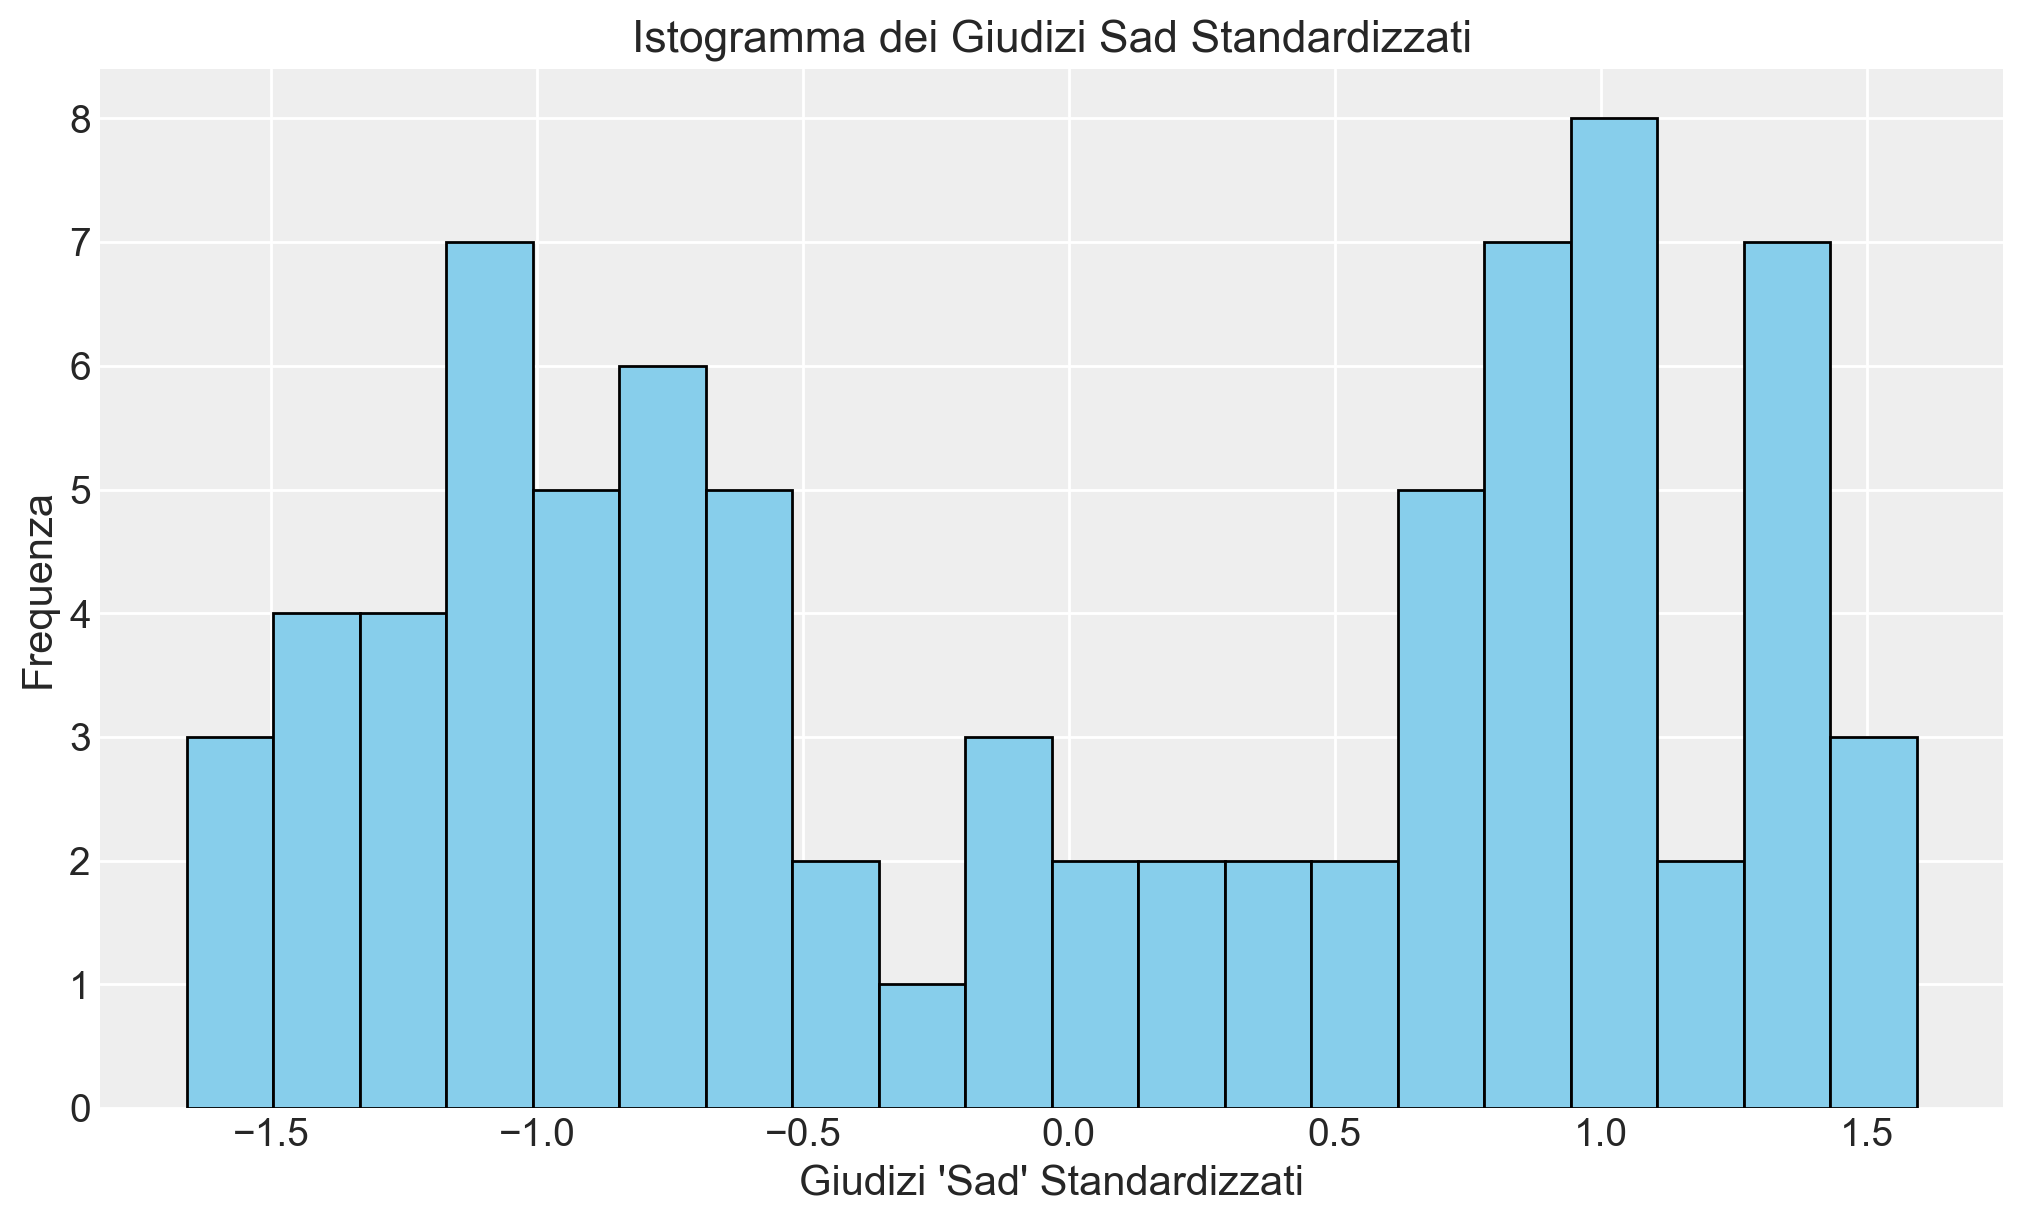

In [42]:
# Standardizzazione dei dati
dati_sad["Sad_z"] = (
    dati_sad["Sad"] - dati_sad["Sad"].mean()
) / dati_sad["Sad"].std()

# Creazione dell'istogramma per i dati standardizzati
plt.figure(figsize=(10, 6))
plt.hist(
    dati_sad["Sad_z"], bins=20, color="skyblue", edgecolor="black"
)
plt.title("Istogramma dei Giudizi Sad Standardizzati")
plt.xlabel("Giudizi 'Sad' Standardizzati")
plt.ylabel("Frequenza")
plt.grid(True)
plt.show()

Il seguente codice Stan è stato ottenuto da [Identifying Bayesian Mixture Models](https://betanalpha.github.io/assets/case_studies/identifying_mixture_models.html) di Michael Betancourt.

In [38]:
stan_file = os.path.join(project_directory, "stan", "bimodal_model.stan")
model = CmdStanModel(stan_file=stan_file)
print(model.code())

data {
  int<lower=0> N;
  vector[N] y;
}
parameters {
  ordered[2] mu;
  array[2] real<lower=0> sigma;
  real<lower=0, upper=1> theta;
}
model {
  sigma ~ normal(0, 2);
  mu ~ normal(0, 2);
  theta ~ beta(5, 5);
  for (n in 1 : N) 
    target += log_mix(theta, normal_lpdf(y[n] | mu[1], sigma[1]),
                      normal_lpdf(y[n] | mu[2], sigma[2]));
}



Questo codice Stan implementa un modello per una mistura di distribuzioni gaussiane. Ecco una spiegazione dettagliata delle varie sezioni del codice:

1. **Blocco `data`**

- **`int<lower=0> N;`**: Definisce il numero di osservazioni, $N$, che deve essere un intero non negativo. Questo rappresenta il numero di dati osservati.
- **`vector[N] y;`**: Definisce un vettore $y$ di lunghezza $N$ che contiene i dati osservati. Ogni elemento di $y$ rappresenta un valore osservato.

2. **Blocco `parameters`**

- **`ordered[2] mu;`**: Definisce un vettore ordinato di lunghezza 2 per i parametri $\mu$, che rappresentano le medie delle due distribuzioni gaussiane nella mistura. La proprietà `ordered` garantisce che $\mu[1] \leq \mu[2]$, il che aiuta a evitare problemi di identificabilità del modello.
  
- **`array[2] real<lower=0> sigma;`**: Definisce un array di 2 elementi per i parametri $\sigma$, che rappresentano le deviazioni standard delle due distribuzioni gaussiane. Il vincolo `<lower=0>` garantisce che le deviazioni standard siano sempre positive.
  
- **`real<lower=0, upper=1> theta;`**: Definisce il parametro $\theta$, che rappresenta la proporzione della prima distribuzione gaussiana nella mistura. Essendo vincolato tra 0 e 1, $\theta$ può essere interpretato come la probabilità che un'osservazione provenga dalla prima distribuzione.

3. **Blocco `model`**

- **`sigma ~ normal(0, 2);`**: Impone una distribuzione a priori normale ($\mathcal{N}(0, 2)$) sui parametri $\sigma$. Questo riflette la convinzione a priori che le deviazioni standard siano distribuite normalmente attorno a 0 con deviazione standard 2.

- **`mu ~ normal(0, 2);`**: Impone una distribuzione a priori normale ($\mathcal{N}(0, 2)$) sui parametri $\mu$. Questo rappresenta l'assunzione che le medie delle due gaussiane siano anch'esse distribuite normalmente attorno a 0 con deviazione standard 2.

- **`theta ~ beta(5, 5);`**: Impone una distribuzione a priori beta ($\text{Beta}(5, 5)$) su $\theta$, che è una distribuzione simmetrica con valori centrati attorno a 0.5. Questo riflette l'assunzione che ciascuna delle due gaussiane abbia una probabilità iniziale del 50% di generare un dato, con un po' di flessibilità.

- **`for (n in 1 : N)`**: Questo ciclo `for` scorre su tutte le osservazioni $y[n]$.

- **`target += log_mix(...)`**: Questa riga è fondamentale per calcolare la log-verosimiglianza del modello. La funzione `log_mix(theta, ...)` calcola la log-verosimiglianza di una mistura di due distribuzioni:
  - **`normal_lpdf(y[n] | mu[1], sigma[1])`**: Calcola la log-verosimiglianza del dato $y[n]$ sotto la prima distribuzione normale con parametri $\mu[1]$ e $\sigma[1]$.
  - **`normal_lpdf(y[n] | mu[2], sigma[2])`**: Calcola la log-verosimiglianza del dato $y[n]$ sotto la seconda distribuzione normale con parametri $\mu[2]$ e $\sigma[2]$.
  - **`log_mix(theta, ..., ...)`**: Mescola queste due log-verosimiglianze pesandole con $\theta$ (per la prima gaussiana) e $1 - \theta$ (per la seconda).

In sintesi, questo modello Stan cerca di adattare una mistura di due distribuzioni gaussiane ai dati osservati $y$. Il modello assume che ciascun dato provenga da una delle due gaussiane e cerca di stimare i parametri delle due distribuzioni (le medie $\mu$ e le deviazioni standard $\sigma$), insieme alla proporzione $\theta$ che indica la probabilità che un dato provenga dalla prima distribuzione. Il codice utilizza distribuzioni a priori per informare il modello sulle aspettative dei parametri, ma è abbastanza flessibile da adattarsi ai dati osservati.

Creiamo il dizionario con i dati nel formato richiesto da Stan.

In [44]:
stan_data = {"N": len(dati_sad["Sad_z"]), "y": dati_sad["Sad_z"]}
print(stan_data)

{'N': 80, 'y': 0    -0.596309
1    -0.870798
2    -0.531045
3    -0.152652
4    -0.912249
        ...   
75    1.273390
76    0.955725
77    0.788841
78    0.957763
79    0.058908
Name: Sad_z, Length: 80, dtype: float64}


Eseguiamo il campionamento.

In [45]:
fit = model.sample(
    data=stan_data,
    iter_warmup=2_000,
    iter_sampling=2_000,
    seed=123,
    show_progress=False,
    show_console=False,
)

Esaminiamo le distribuzioni a posteriori dei parametri del modello.

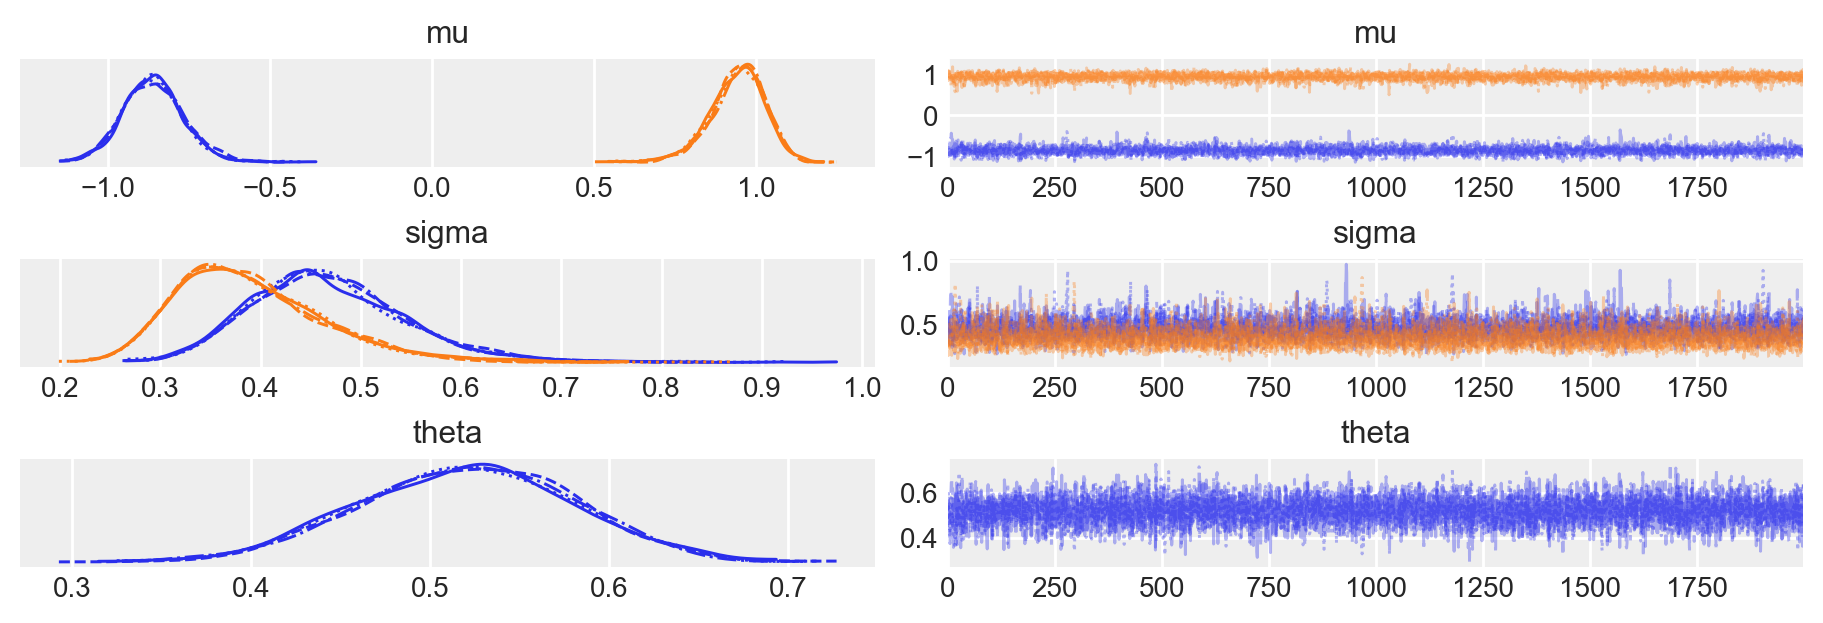

In [49]:
az.plot_trace(fit, var_names=["mu", "sigma", "theta"], figsize=(9, 3))
plt.show()

In [50]:
az.summary(fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[0],-0.859,0.096,-1.045,-0.688,0.002,0.001,3873.0,3587.0,1.0
mu[1],0.942,0.085,0.791,1.103,0.001,0.001,6252.0,4828.0,1.0
sigma[0],0.468,0.079,0.334,0.623,0.001,0.001,4663.0,4282.0,1.0
sigma[1],0.390,0.076,0.267,0.532,0.001,0.001,4461.0,4506.0,1.0
theta,0.520,0.060,0.410,0.633,0.001,0.001,5590.0,5627.0,1.0


Rappresentiamo graficamente la distribuzione ottenuta dai parametri medi posteriori.

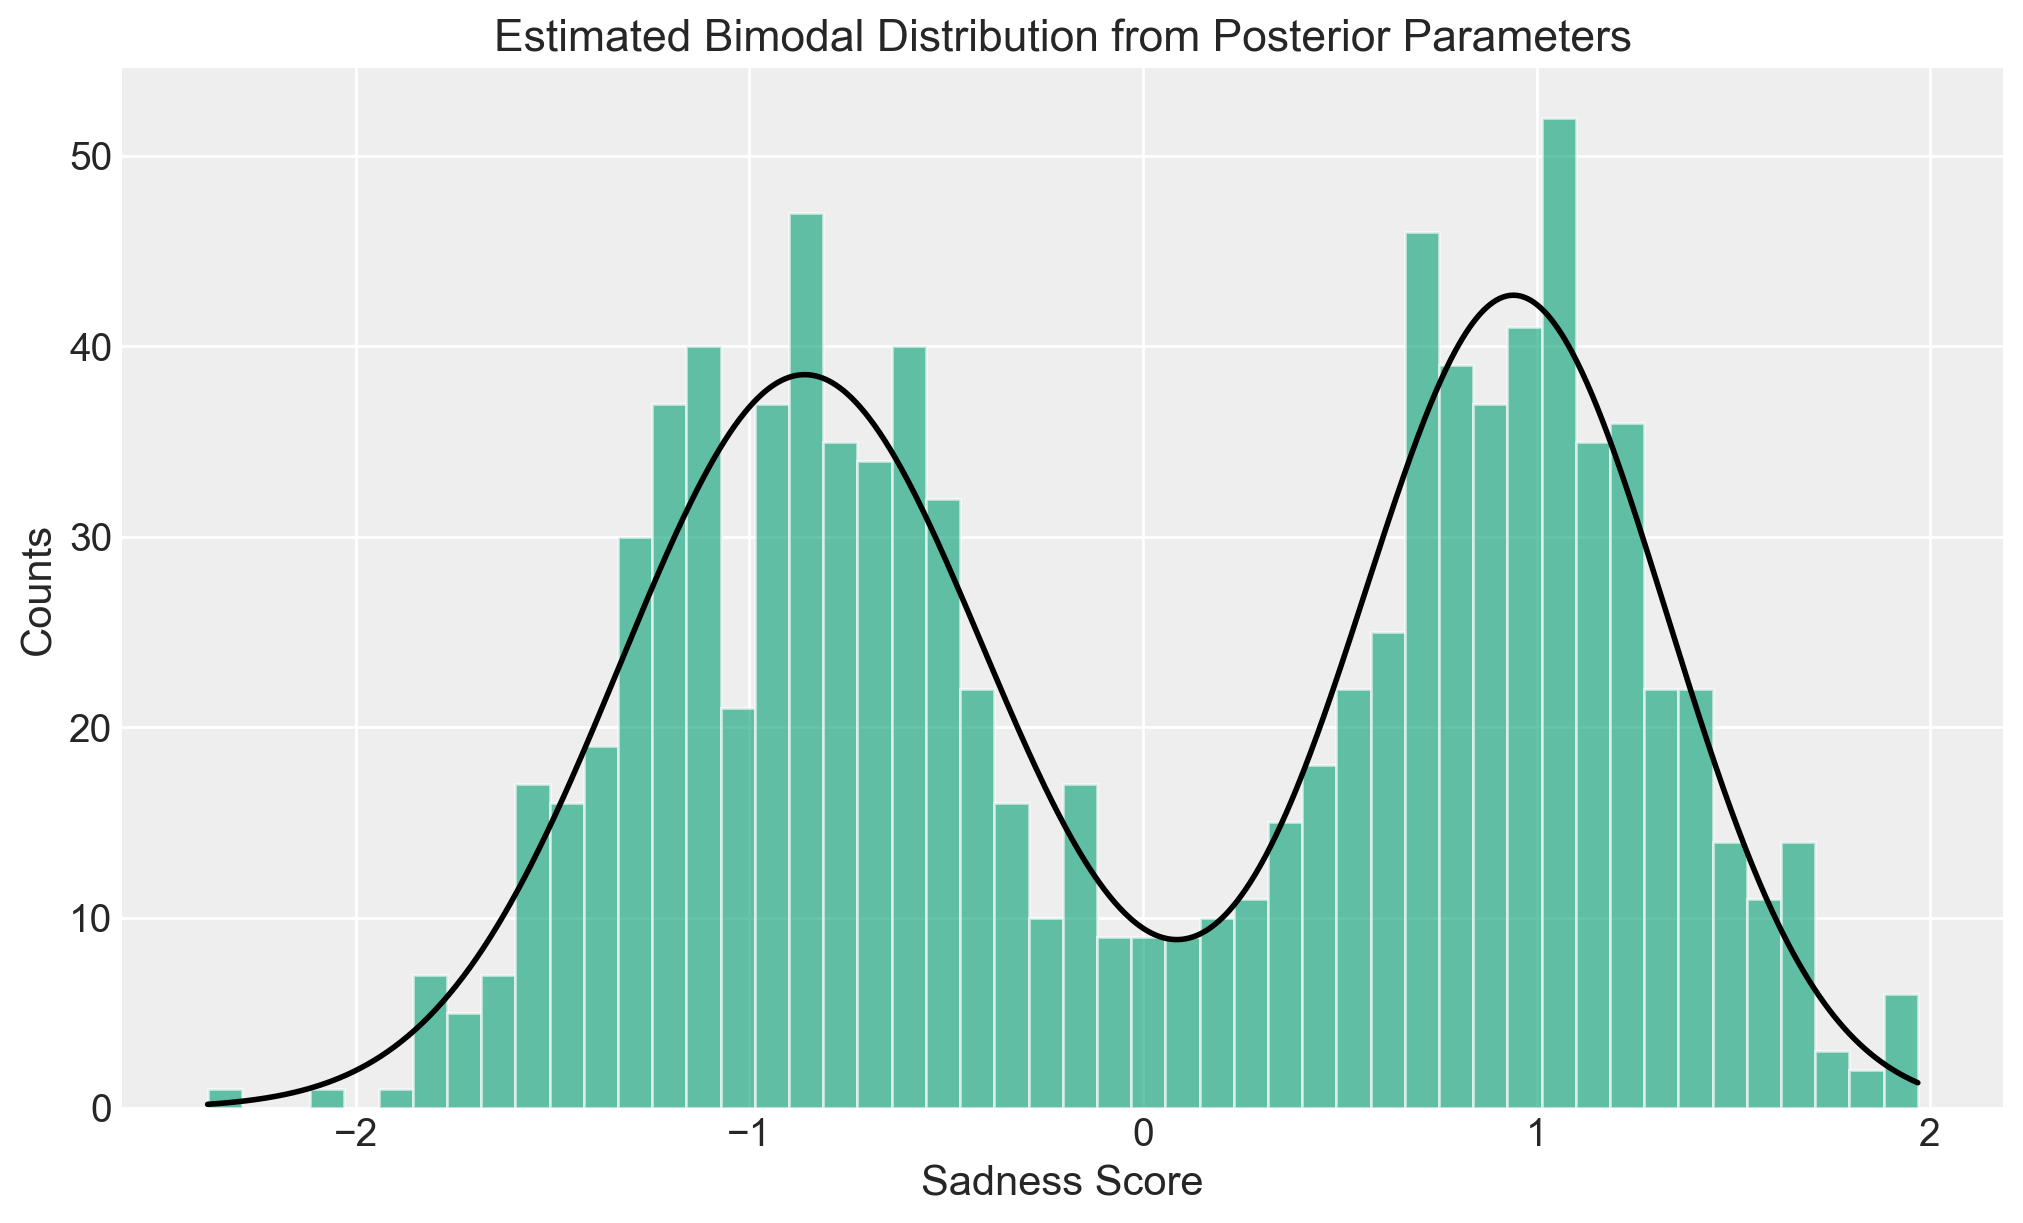

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Using the provided posterior estimates
mu_0 = -0.859
mu_1 = 0.942
sigma_0 = 0.468
sigma_1 = 0.390
theta = 0.520  # Probability for the first component (mu_0)

# Assuming dati_sad is your DataFrame, you need to provide the actual data
# For this example, I'll generate some random data
np.random.seed(42)
data = np.concatenate(
    [
        np.random.normal(mu_0, sigma_0, int(1000 * theta)),
        np.random.normal(mu_1, sigma_1, int(1000 * (1 - theta))),
    ]
)

# Generate the histogram from the data
fig, axes = plt.subplots(1, figsize=(10, 6))

# Plot the histogram with actual counts
counts, bins, _ = axes.hist(data, bins=50, alpha=0.6, color="g", density=False)

# Calculate the KDE with a higher resolution
x = np.linspace(data.min(), data.max(), 1000)
kde = theta * norm.pdf(x, loc=mu_0, scale=sigma_0) + (1 - theta) * norm.pdf(
    x, loc=mu_1, scale=sigma_1
)

# Scale the KDE to match the histogram's area
hist_area = np.sum(counts) * np.diff(bins)[0]
kde_scaled = kde * hist_area

# Plot the KDE
axes.plot(x, kde_scaled, linewidth=2, color="black")

# Additional plot settings
axes.set_title("Estimated Bimodal Distribution from Posterior Parameters")
axes.set_xlabel("Sadness Score")
axes.set_ylabel("Counts")

plt.show()

Notiamo la buona corrispondenza tra il grafico precedente e quello sopra che rappresenta i dati in input.

Possiamo anche convertire i parametri recuperati in modo che siano espressi sulla scala dei dati grezzi.

In [66]:
# I valori di media e deviazione standard della distribuzione originale
mean_original = dati_sad["Sad"].mean()
std_original = dati_sad["Sad"].std()

# Parametri posteriori delle distribuzioni standardizzate
mu_0_standardized = -0.859
mu_1_standardized = 0.942
sigma_0_standardized = 0.468
sigma_1_standardized = 0.390

# Convertire i parametri alla scala originale
mu_0_original = mu_0_standardized * std_original + mean_original
mu_1_original = mu_1_standardized * std_original + mean_original
sigma_0_original = sigma_0_standardized * std_original
sigma_1_original = sigma_1_standardized * std_original

In [65]:
print(
    f"Media a posteriori della prima sottopopolazione: {mu_0_original:.2f}\nMedia a posteriori della seconda sottopopolazione: {mu_1_original:.2f}"
)
print(
    f"Deviazione standard a poseriori della prima sottopopolazione: {sigma_0_original:.2f}\nDeviazione standard a posteriori della seconda sottopopolazione: {sigma_1_original:.2f}"
)

Media a posteriori della prima sottopopolazione: 18.89
Media a posteriori della seconda sottopopolazione: 60.55
Deviazione standard a poseriori della prima sottopopolazione: 10.83
Deviazione standard a posteriori della seconda sottopopolazione: 9.02


Nella simulazione, i valori di $\mu$ erano $[20, 60]$ e i due valori di $\sigma$ erano entrambi pari a 10. Si osserva quindi una corrispondenza molto buona tra i valori utilizzati per simulare i dati e i parametri stimati per ciascun gruppo. È importante notare che il codice Stan non includeva l'informazione che assegnava ogni osservazione a un gruppo specifico. Questo dimostra come la tecnica della mistura di gaussiane sia in grado di classificare correttamente le osservazioni dei dati campionari nelle diverse sottopopolazioni e di stimare con precisione i parametri per ciascuna di esse.

## Considerazioni Conlusive

In questo capitolo, abbiamo esplorato l'applicazione dei modelli di mistura gaussiana nel contesto della ricerca psicologica, utilizzando come esempio uno studio sugli effetti del training di mindfulness sui giudizi di tristezza.

Implicazioni per la ricerca psicologica:

- Questi modelli possono aiutare i ricercatori a identificare sottogruppi nascosti all'interno dei loro dati, portando a una comprensione più sfumata dei fenomeni psicologici.
- L'approccio bayesiano offre una flessibilità che può essere particolarmente utile quando si lavora con campioni di dimensioni ridotte o dati complessi.

In conclusione, i modelli di mistura gaussiana rappresentano uno strumento statistico che può arricchire l'analisi dei dati in psicologia, permettendo ai ricercatori di scoprire strutture latenti e di modellare la complessità intrinseca dei fenomeni psicologici.

## Informazioni sull'Ambiente di Sviluppo {.unnumbered}

In [38]:
%load_ext watermark
%watermark -n -u -v -iv -m 

Last updated: Sat Jul 27 2024

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.26.0

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.5.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

numpy     : 1.26.4
cmdstanpy : 1.2.4
matplotlib: 3.9.1
logging   : 0.5.1.2
arviz     : 0.18.0
scipy     : 1.14.0
seaborn   : 0.13.2
pandas    : 2.2.2

